In [1]:
%reset
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.ticker as mticker
import warnings; warnings.filterwarnings('ignore')
import cmocean
from xgcm import Grid
import scipy.io

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


## Reading in the 1/4 degree data and performing energy decomposition

In [2]:
%cd /glade/p/univ/unyu0004/gmarques/NeverWorld2/nw2_0.25deg_N15_baseline

fs=xr.open_dataset('static.nc', decode_times=False)
os=xr.open_dataset('ocean.stats.nc', decode_times=False)
av= xr.open_dataset('averages_00031502.nc', decode_times=False)  #5-day average

%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/Vertical_Structure_with_Jake


/glade/p/univ/unyu0004/gmarques/NeverWorld2/nw2_0.25deg_N15_baseline
/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/Vertical_Structure_with_Jake


/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/Vertical_Structure_with_Jake
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


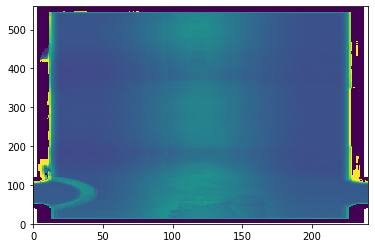

In [3]:
%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/Vertical_Structure_with_Jake

ft= scipy.io.loadmat('scaledepth_depth_025.mat')
depths_025=ft['Thermocline']
ft= scipy.io.loadmat('scaledepth_depth_00625.mat')
depths_00625=ft['Thermocline']
print(depths_025)
plt.pcolor(depths_025,vmin=0,vmax=1)

In [4]:
%%time
xh_025 = fs.xh.values
yh_025 = fs.yh.values
# #COMPUTE velocity components for decomposing KE:
Nlayers=15

grid= Grid(av, coords={'X': {'center': 'xh', 'outer': 'xq'}, #This tells the grid where xh, xq, yh, and yq are defined.
                        'Y': {'center': 'yh', 'outer': 'yq'}});
h  = av['h'].mean('time').fillna(0.)
Depth=h.sum('zl')
print('done part 1')
#Outputs are comprised of 100 5-day averages.
u  = av['u'];  u = grid.interp(u,axis='X')#.fillna(0.); 
ubar=u.mean('time')
print('done part 2')
v  = av['v'];  v = grid.interp(v,axis='Y')#.fillna(0.);
vbar=v.mean('time')

uprime=u-ubar
vprime=v-vbar

print(uprime.shape)
area_t=fs['area_t']

done part 1
done part 2
(100, 15, 560, 240)
CPU times: user 13.9 s, sys: 11.4 s, total: 25.3 s
Wall time: 54.3 s


In [22]:
%%time
# The mean BT and BC KE values:
ubar_TW=ubar*h/Depth; 
ubar_BT=ubar_TW.sum('zl')
ubar_BC=ubar-ubar_BT;

vbar_TW=vbar*h/Depth
vbar_BT=vbar_TW.sum('zl')
vbar_BC=vbar-vbar_BT;

KE_mean_BT=0.5*(vbar_BT**2+ubar_BT**2) #dim y,x
KE_mean_BC=(0.5*(vbar_BC**2+ubar_BC**2)*h/Depth).sum('zl') #dim y,x

print('done 1')

#Eddy BT and BC KE parts:
uprime_BT=(uprime*h/Depth).sum('zl')
uprime_BC=uprime-uprime_BT
vprime_BT=(vprime*h/Depth).sum('zl')
vprime_BC=vprime-vprime_BT
    
KE_eddy_BT=(0.5*(vprime_BT**2+uprime_BT**2)).mean('time')
KE_eddy_BC=((0.5*(vprime_BC**2+uprime_BC**2)*h/Depth).sum('zl')).mean('time')


# #Total kinetic energy:
KE_BT_tot_025=KE_eddy_BT+KE_mean_BT
KE_BC_tot_025=KE_eddy_BC+KE_mean_BC
KE_tot_025=KE_BT_tot_025+KE_BC_tot_025


fraction_BT_025=KE_BT_tot_025/KE_tot_025
fraction_BT_mean_025=KE_mean_BT/KE_tot_025
fraction_BT_eddy_025=KE_eddy_BT/KE_tot_025

fraction_BC_025=KE_BC_tot_025/KE_tot_025 #when you divide zero/zero it's a nan
fraction_BC_mean_025=KE_mean_BC/KE_tot_025
fraction_BC_eddy_025=KE_eddy_BC/KE_tot_025

KE_eddy_025 = KE_eddy_BT+ KE_eddy_BC
KE_mean_025 = KE_mean_BT+ KE_eddy_BC

done 1
CPU times: user 3.74 s, sys: 6.93 s, total: 10.7 s
Wall time: 10.7 s


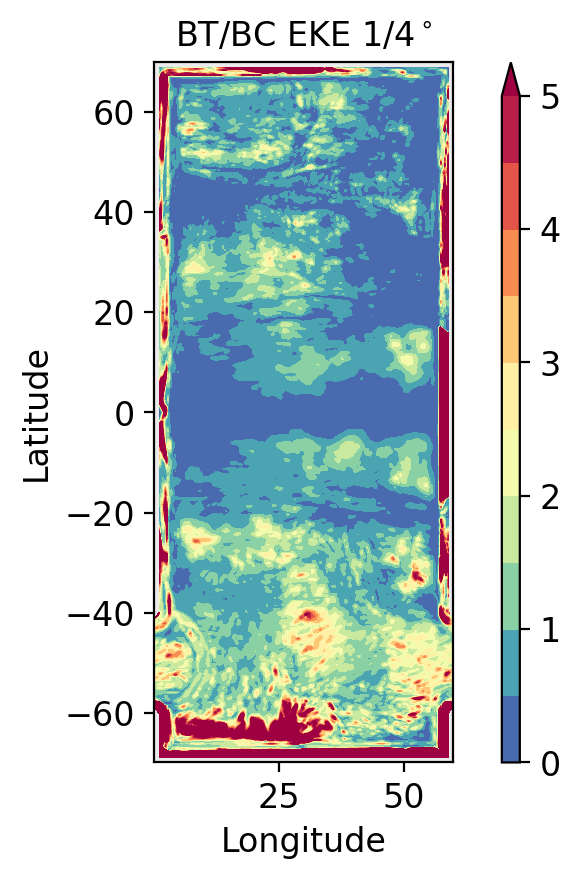

In [23]:
fig = plt.figure(figsize=(3, 5), dpi=200, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_title('BT/BC EKE 1/4$^\circ$',fontsize=12)
ax1.set_xlabel('Longitude',fontsize=12)
ax1.set_ylabel('Latitude',fontsize=12)
ax1.tick_params(labelsize=12); 
ax2.tick_params(labelsize=12)

levels=np.linspace(0,5,11)
#levels=(0,1,2,3,4,5)
plotted =ax1.contourf(xh_025,yh_025,KE_eddy_BT/KE_eddy_BC,levels=levels,cmap='Spectral_r',extend='max')

ax1.set_aspect('equal', 'box')
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=12);
#
plt.show()

## Reading in the 1/16 degree data and performing energy decomposition

In [5]:
%cd /glade/p/univ/unyu0004/gmarques/NeverWorld2/nw2_0.0625deg_N15_baseline

fs=xr.open_dataset('static.nc', decode_times=False)
os=xr.open_dataset('ocean.stats.nc', decode_times=False)
av     = xr.open_dataset('averages_00006002.nc', decode_times=False)  #5-day average

%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/


/glade/p/univ/unyu0004/gmarques/NeverWorld2/nw2_0.0625deg_N15_baseline
/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis


In [40]:
%%time
#COMPUTE KE AND THEN WEIGH BY THICKNESS
xh_00625 = fs.xh.values
yh_00625 = fs.yh.values

# # #COMPUTE velocity components for decomposing KE:
# Nlayers=15

grid= Grid(av, coords={'X': {'center': 'xh', 'outer': 'xq'}, #This tells the grid where xh, xq, yh, and yq are defined.
                       'Y': {'center': 'yh', 'outer': 'yq'}});
# h  = av['h'].mean('time').fillna(0.)
# Depth=h.sum('zl')
# print('done part 1')
# #Outputs are comprised of 100 5-day averages.
# u  = av['u'];  u = grid.interp(u,axis='X')#.fillna(0.); 
# ubar=u.mean('time')
# print('done part 2')
# v  = av['v'];  v = grid.interp(v,axis='Y')#.fillna(0.);
# vbar=v.mean('time')

# uprime=u-ubar
# vprime=v-vbar

# print(uprime.shape)
# area_t=fs['area_t']

Coriolis = fs.Coriolis; 
Coriolis=grid.interp(Coriolis,axis='X'); 
Coriolis = grid.interp(Coriolis,axis='Y')
Beta = Coriolis.differentiate('yh')*360/(2*np.pi*6378000)

print(Beta)

<xarray.DataArray (yh: 2240, xh: 960)>
array([[7.845584e-12, 7.845584e-12, 7.845584e-12, ..., 7.845584e-12,
        7.845584e-12, 7.845584e-12],
       [7.856043e-12, 7.856043e-12, 7.856043e-12, ..., 7.856043e-12,
        7.856043e-12, 7.856043e-12],
       [7.879051e-12, 7.879051e-12, 7.879051e-12, ..., 7.879051e-12,
        7.879051e-12, 7.879051e-12],
       ...,
       [7.879051e-12, 7.879051e-12, 7.879051e-12, ..., 7.879051e-12,
        7.879051e-12, 7.879051e-12],
       [7.856043e-12, 7.856043e-12, 7.856043e-12, ..., 7.856043e-12,
        7.856043e-12, 7.856043e-12],
       [7.845584e-12, 7.845584e-12, 7.845584e-12, ..., 7.845584e-12,
        7.845584e-12, 7.845584e-12]], dtype=float32)
Coordinates:
  * yh       (yh) float64 -69.97 -69.91 -69.84 -69.78 ... 69.84 69.91 69.97
  * xh       (xh) float64 0.03125 0.09375 0.1562 0.2188 ... 59.84 59.91 59.97
CPU times: user 56 ms, sys: 117 µs, total: 56.2 ms
Wall time: 55 ms


In [4]:
%%time
# The mean BT and BC KE values:
ubar_TW=ubar*h/Depth; 
ubar_BT=ubar_TW.sum('zl')
ubar_BC=ubar-ubar_BT;

vbar_TW=vbar*h/Depth
vbar_BT=vbar_TW.sum('zl')
vbar_BC=vbar-vbar_BT;

KE_mean_BT=0.5*(vbar_BT**2+ubar_BT**2) #dim y,x
KE_mean_BC=(0.5*(vbar_BC**2+ubar_BC**2)*h/Depth).sum('zl') #dim y,x

print('done 1')

#Eddy BT and BC KE parts:
uprime_BT=(uprime*h/Depth).sum('zl')
uprime_BC=uprime-uprime_BT
vprime_BT=(vprime*h/Depth).sum('zl')
vprime_BC=vprime-vprime_BT
    
KE_eddy_BT=(0.5*(vprime_BT**2+uprime_BT**2)).mean('time')
KE_eddy_BC=((0.5*(vprime_BC**2+uprime_BC**2)*h/Depth).sum('zl')).mean('time')


# #Total kinetic energy:
KE_BT_tot_00625=KE_eddy_BT+KE_mean_BT
KE_BC_tot_00625=KE_eddy_BC+KE_mean_BC
KE_tot_00625=KE_BT_tot_00625+KE_BC_tot_00625


fraction_BT_00625=KE_BT_tot_00625/KE_tot_00625
fraction_BT_mean_00625=KE_mean_BT/KE_tot_00625
fraction_BT_eddy_00625=KE_eddy_BT/KE_tot_00625

fraction_BC_00625=KE_BC_tot_00625/KE_tot_00625 #when you divide zero/zero it's a nan
fraction_BC_mean_00625=KE_mean_BC/KE_tot_00625
fraction_BC_eddy_00625=KE_eddy_BC/KE_tot_00625

KE_eddy_00625 = KE_eddy_BT+ KE_eddy_BC
KE_mean_00625 = KE_mean_BT+ KE_eddy_BC

done 1
CPU times: user 1min 8s, sys: 2min 12s, total: 3min 20s
Wall time: 3min 20s


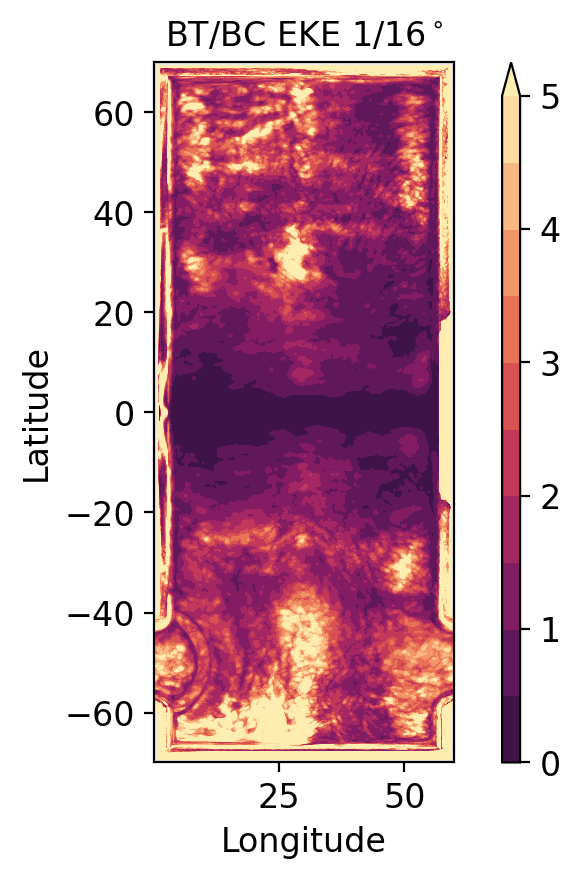

In [5]:
fig = plt.figure(figsize=(3, 5), dpi=200, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_title('BT/BC EKE 1/16$^\circ$',fontsize=12)
ax1.set_xlabel('Longitude',fontsize=12)
ax1.set_ylabel('Latitude',fontsize=12)
ax1.tick_params(labelsize=12); 
ax2.tick_params(labelsize=12)

levels=np.linspace(0,5,11)
#levels=(0,1,2,3,4,5)
plotted =ax1.contourf(xh_00625,yh_00625,KE_eddy_BT/KE_eddy_BC,levels=levels,cmap=cmocean.cm.matter_r,extend='max')

ax1.set_aspect('equal', 'box')
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=12);
#
plt.show()

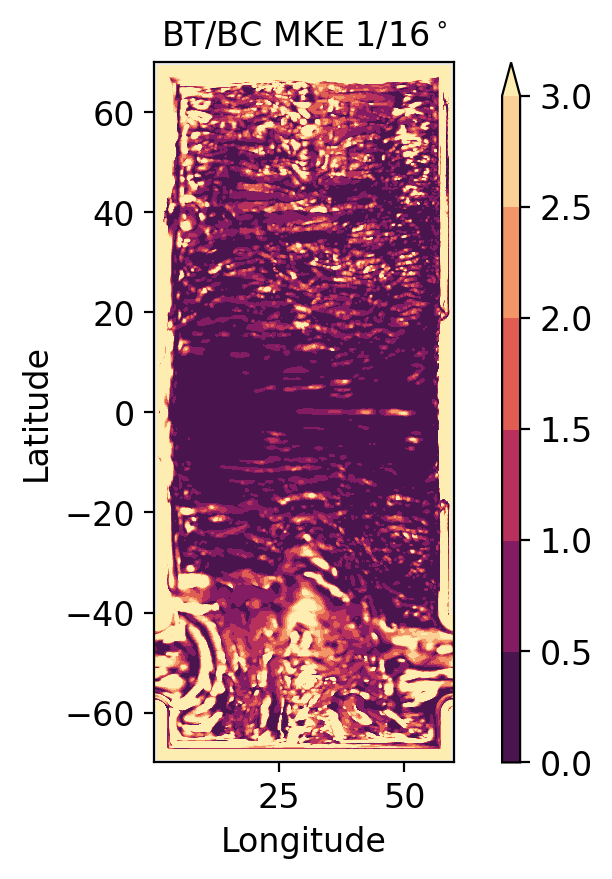

In [9]:
fig = plt.figure(figsize=(3, 5), dpi=200, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_title('BT/BC MKE 1/16$^\circ$',fontsize=12)
ax1.set_xlabel('Longitude',fontsize=12)
ax1.set_ylabel('Latitude',fontsize=12)
ax1.tick_params(labelsize=12); 
ax2.tick_params(labelsize=12)

levels=np.linspace(0,3,7)
#levels=(0,1,2,3,4,5)
plotted =ax1.contourf(xh_00625,yh_00625,KE_mean_BT/KE_mean_BC,levels=levels,cmap=cmocean.cm.matter_r,extend='max')

ax1.set_aspect('equal', 'box')
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=12);
#
plt.show()

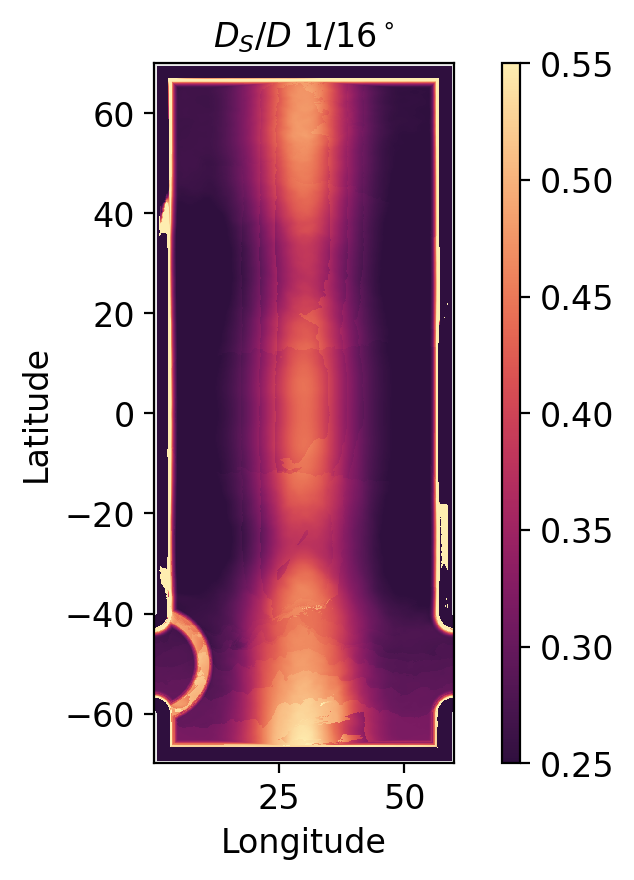

In [17]:
fig = plt.figure(figsize=(3, 5), dpi=200, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_title('$D_S/D$ 1/16$^\circ$',fontsize=12)
ax1.set_xlabel('Longitude',fontsize=12)
ax1.set_ylabel('Latitude',fontsize=12)
ax1.tick_params(labelsize=12); 
ax2.tick_params(labelsize=12)

#levels=np.linspace(0.,.05,51) #not logarithmic colormap
levels=np.linspace(0,1000,111)
plotted =ax1.pcolor(xh_00625,yh_00625,depths_00625,cmap=cmocean.cm.matter_r,vmin=0.25,vmax=.55)

ax1.set_aspect('equal', 'box')
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=12);
#
plt.show()

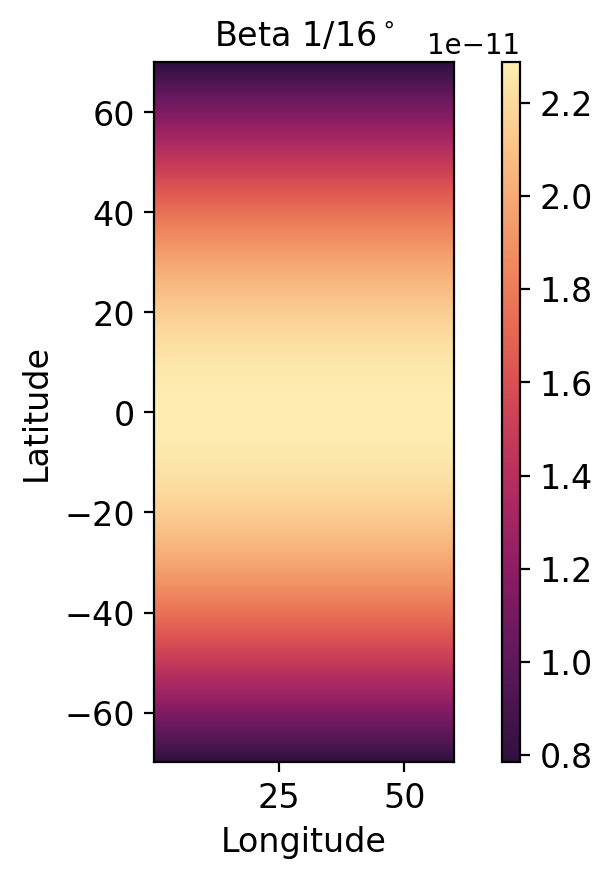

In [41]:
fig = plt.figure(figsize=(3, 5), dpi=200, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_title('Beta 1/16$^\circ$',fontsize=12)
ax1.set_xlabel('Longitude',fontsize=12)
ax1.set_ylabel('Latitude',fontsize=12)
ax1.tick_params(labelsize=12); 
ax2.tick_params(labelsize=12)

#levels=np.linspace(0.,.05,51) #not logarithmic colormap
levels=np.linspace(0,1000,111)
plotted =ax1.pcolor(xh_00625,yh_00625,Beta,cmap=cmocean.cm.matter_r)

ax1.set_aspect('equal', 'box')
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=12);
#
plt.show()

Text(0.5, 1.0, '1/16$^\\circ$ BT/BC MKE Ratio')

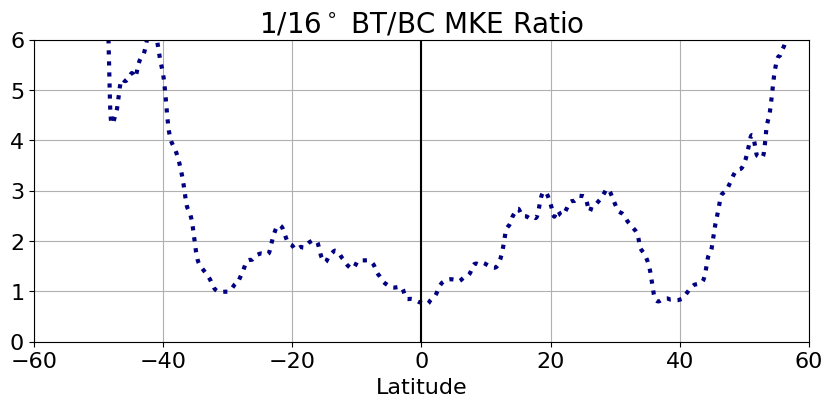

In [6]:
window=120

plt.figure(figsize=(10, 4), dpi= 100, facecolor='w', edgecolor='k')
#plt.plot(yh,np.nanmean(fraction_BT,axis=1),'-',c='#82cafc',linewidth=3)

plt.plot(yh_00625,np.convolve((fraction_BT_mean_00625[:,10:-10]).mean('xh')/(fraction_BC_mean_00625[:,470:490]).mean('xh').compute(), np.ones((window,))/window, mode='same'),':',c=[0,0,0.5],linewidth=3)
#plt.plot(yh_00625,np.convolve((fraction_BT_mean_00625[:,470:490]).mean('xh')/(fraction_BC_mean_00625[:,470:490]).mean('xh').compute(), np.ones((window,))/window, mode='same'),':',c=[0,0,0.5],linewidth=3)

plt.grid()

plt.plot([0, 0],[0, 6],'-',color=[0,0,0])
plt.xlim(-60, 60); plt.xticks(fontsize=16);
plt.ylim(0,6); plt.yticks(fontsize=16);
plt.xlabel('Latitude',fontsize=16)
plt.title('1/16$^\circ$ BT/BC MKE Ratio',fontsize=20)

Text(0.5, 1.0, '1/16$^\\circ$ Ratios')

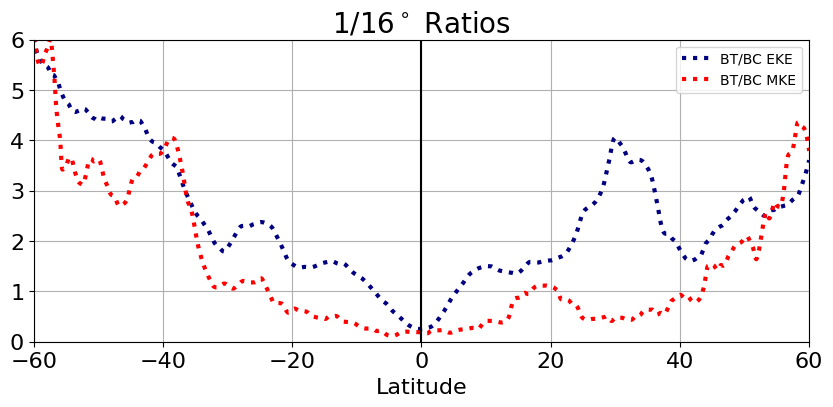

In [19]:
window=120

plt.figure(figsize=(10, 4), dpi= 100, facecolor='w', edgecolor='k')
#plt.plot(yh,np.nanmean(fraction_BT,axis=1),'-',c='#82cafc',linewidth=3)

plt.plot(yh_00625,np.convolve((fraction_BT_eddy_00625[:,470:490]).mean('xh')/(fraction_BC_eddy_00625[:,470:490]).mean('xh').compute(), np.ones((window,))/window, mode='same'),':',c=[0,0,0.5],linewidth=3,label='BT/BC EKE')
plt.plot(yh_00625,np.convolve((fraction_BT_mean_00625[:,470:490]).mean('xh')/(fraction_BC_mean_00625[:,470:490]).mean('xh').compute(), np.ones((window,))/window, mode='same'),':',c='r',linewidth=3,label='BT/BC MKE')

#plt.plot(yh_00625,np.convolve((fraction_BT_eddy_00625).mean('xh')/(fraction_BC_eddy_00625).mean('xh').compute(), np.ones((window,))/window, mode='same'),':',c=[0,0,0.5],linewidth=3)
plt.grid()

plt.plot([0, 0],[0, 6],'-',color=[0,0,0])
plt.xlim(-60, 60); plt.xticks(fontsize=16);
plt.ylim(0,6); plt.yticks(fontsize=16);
plt.xlabel('Latitude',fontsize=16)
plt.legend()
plt.title('1/16$^\circ$ Ratios',fontsize=20)

Text(0.5, 1.0, '1/16$^\\circ$ (Density scale depth)/(Depth)')

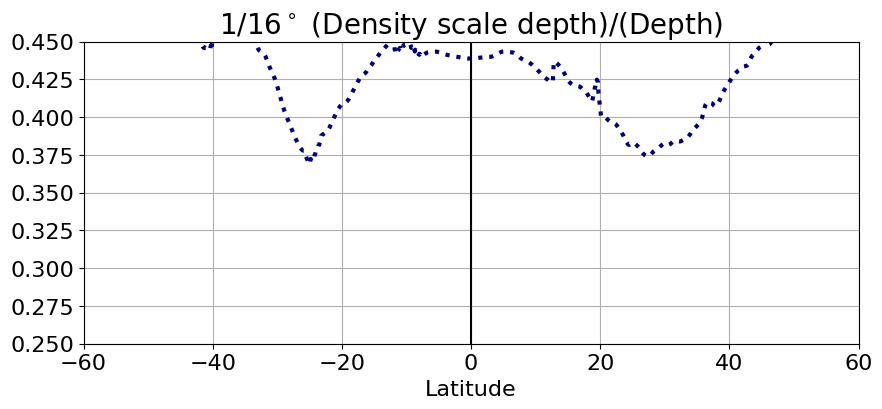

In [17]:
window=120

plt.figure(figsize=(10, 4), dpi= 100, facecolor='w', edgecolor='k')
#plt.plot(yh,np.nanmean(fraction_BT,axis=1),'-',c='#82cafc',linewidth=3)

plt.plot(yh_00625,np.nanmean(depths_00625[:,470:490],axis=1),':',c=[0,0,0.5],linewidth=3)
plt.grid()

plt.plot([0, 0],[0, 5],'-',color=[0,0,0])
plt.xlim(-60, 60); plt.xticks(fontsize=16);
plt.ylim(.25,.45); plt.yticks(fontsize=16);
plt.xlabel('Latitude',fontsize=16)
plt.title('1/16$^\circ$ (Density scale depth)/(Depth)',fontsize=20)

In [45]:
depths_00625.shape

(2240, 960)

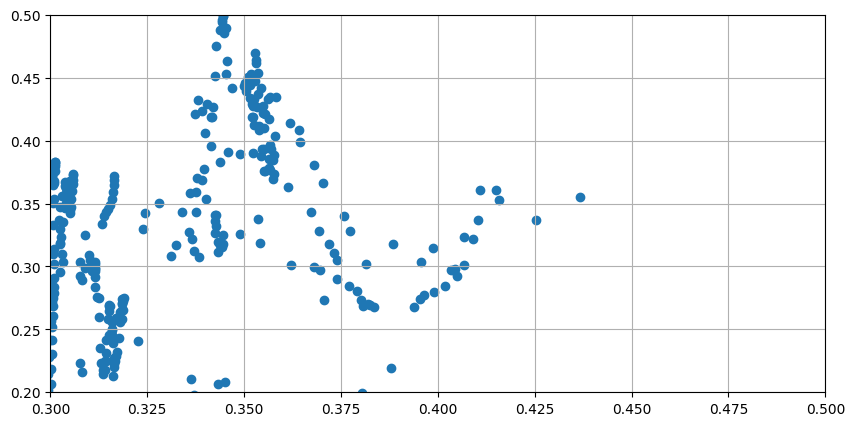

In [34]:
window=30

plt.figure(figsize=(10, 5), dpi= 100, facecolor='w', edgecolor='k')

plt.scatter(np.nanmean(depths_025,axis=1),np.nanmean((fraction_BT_eddy_025),axis=1))
plt.ylim(0.2,.5);
plt.xlim(.3,.5)
plt.grid()




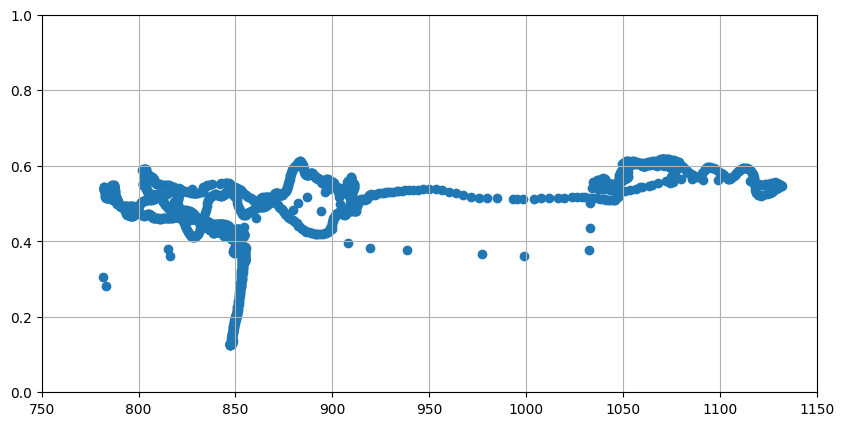

In [98]:
window=30

plt.figure(figsize=(10, 5), dpi= 100, facecolor='w', edgecolor='k')

plt.scatter(np.nanmean(depths_00625,axis=1),np.nanmean((fraction_BT_eddy_00625),axis=1))
plt.ylim(0,1);
plt.xlim(750,1150)
plt.grid()

In [77]:
depths_0125.shape

(1120, 480)